# Материалы
* [Презентация] (https://files.sberdisk.ru/s/FSNseQqCb37ieTZ)
* [Дашборд] (https://public.tableau.com/views/FinalProject_16497953753850/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)

# Банки — Сегментация пользователей по потреблению

## Задача 
    Проанализировать клиентов регионального банка и сегментировать пользователей по количеству потребляемых продуктов.



## Заказчики
    Департамент Розничного бизнеса

## Цель

    Предложение определенных продуктов для удержания клиентов

## Описание данных

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from scipy import stats
import plotly.express as px
import re
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
import scipy.stats as stat

pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

## Предобработка данных

- Исследовать пропущенные значения
- Исследовать соответствие типов
- Исследовать дубликаты
- Проверить корректность наименований колонок
- Переименовать колонки
- Удалить дубликаты
- Привести типы
- Заменить пропущенные значения

In [2]:
! ls /datasets/

 31231312t.csv
 ab_project_marketing_events.csv
 ab_project_marketing_events_us.csv
 ad_costs.csv
 ad_costs_new.csv
 ad_costs_us.csv
 ad_data
 ad_data_2.csv
 ad_data.csv
 ad_data_eng.csv
 agent_call_times.csv
 Alcohol_Sales.csv
 apple_counts.csv
 apple_quality.csv
 app_stats.csv
 arrivals.xlsx
 auto_cons.csv
 auto_cons_us.csv
 auto.csv
 autos.csv
 bank_dataset.csv
 bank_sales.csv
 be.csv
 BeerWineLiquor.csv
 behavioral_cohorts.csv
 bike_injuries.csv
 book_orders.csv
 borough_boundaries.csv
 Borough_Boundaries.csv
 cal_housing_data.csv
 calls.csv
 call_type_dictionary.csv
 car_data.csv
 cars.csv
 cars_label.csv
 cases.csv
 cats_data.csv
 ch02_les03_costs.csv
 ch02_les03_events.csv
 ch02_les03_orders.csv
 ch02_problems01_users.csv
 ch02_problems01_visits
 ch02_problems01_visits.csv
 ch02_problems02_costs.csv
 ch02_problems02_events.csv
 ch02_problems02_orders.csv
 ch02_problems02_users.csv
 ch02_problems02_visits.csv
 ch02_problems03_visits.csv
 ch03_problems03_active_users.csv
 ch03_vis

In [3]:
try:
    data = pd.read_csv('/datasets/bank_dataset.csv')
except:
    print("Не удалось загрузить датасет")
    
data.head(3)

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,"101,348.88",1
1,15690047,608,Рыбинск,Ж,41,1,"83,807.86",1,0,1,"112,542.58",0
2,15662040,502,Ярославль,Ж,42,8,"159,660.80",3,1,0,"113,931.57",1


In [ ]:
print('Размер датасета:', data.shape)

In [ ]:
data.info()

In [ ]:
# приводим колонки к нижнему регистру
data.columns = data.columns.str.lower()

In [ ]:
# проверка на пропуски
data.isna().sum()

In [ ]:
# исследуем null
def null_analyse(data, col):
    obs_all= data[col].value_counts()
    obs_null= data.query("balance.isnull()")[col].value_counts()
    
    df_null = pd.DataFrame(dict(obs_all = obs_all, obs_null = obs_null)).reset_index()
    df_null['perc_null'] = 100 * df_null.obs_null / df_null.obs_all
    return pd.DataFrame(df_null.sort_values(by='perc_null', ascending=False))

In [ ]:
for col in list(filter(lambda x: x not in ['userid', 'score', 'balance', 'estimated_salary'], data.columns)):
    print(col)
    print(null_analyse(data, col), "\n\n")

In [ ]:
# проверка на дупликаты
data.duplicated().sum()

In [ ]:
for col in data.columns:
    print(col)
    print(data[col].duplicated().sum(), '\n')

In [ ]:
data.describe()

In [ ]:
data.groupby('churn').describe()

###### Вывод

- датасет состоит из 10к наблюдений
- привели все нэйминги колонок к нижнему регистру
- имеются незаполненные данные в колонке balance (в двух городах)
    - в городе Ростов Великий все данные заполнены
- полных дублей строк не найдено



Портрет клиента:
- 38 лет
- сумма на счету - 120к
- имеет 2 продукта
- имеет кредитку
- зарплата 100к


Уходят чаще клиенты в возрасте - средний возраст ушедших клиентов 45 лет

## Исследовательский анализ данных

- изучить количественные параметры и построить гистограммы для каждого параметра
- убрать редкие и часто встречающиеся значения
- посмотреть есть ли выбросы в заработной плане и балансе на счете. Построить диаграмму размаха и выявить аномалии
- проанализировать клиентов в разрезе городов. Определить самый популярный город
- изучить средние значения и стандартные отклонения

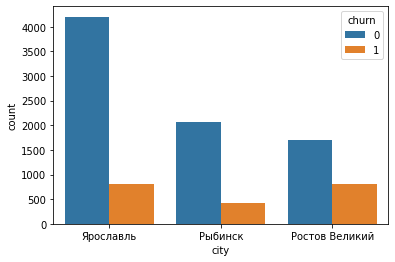

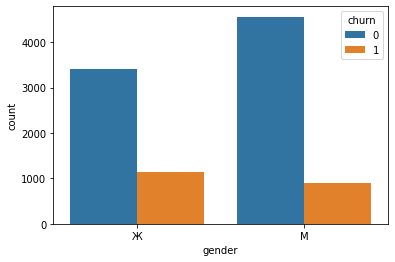

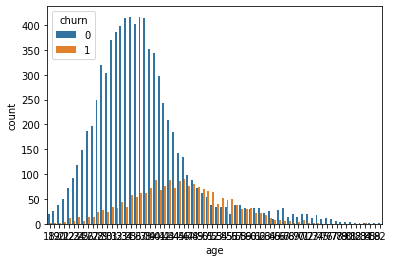

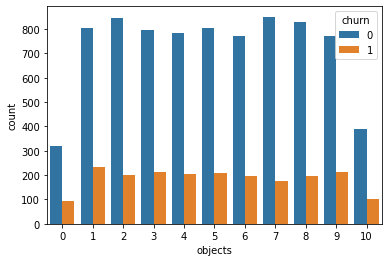

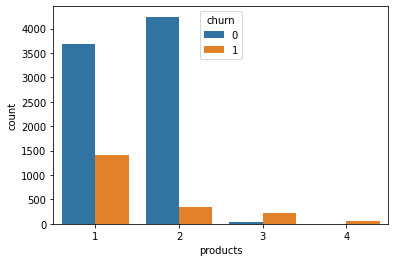

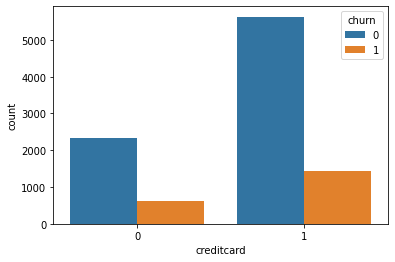

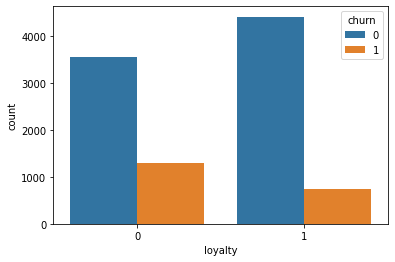

In [14]:
# Для дискретных переменных строим обычные столбчатые диаграммы.
for col in data.drop(['churn', 'balance', 'estimated_salary', 'userid', 'score'], axis = 1).columns:
    sns.countplot(data=data, x=col, hue='churn')
    plt.show()

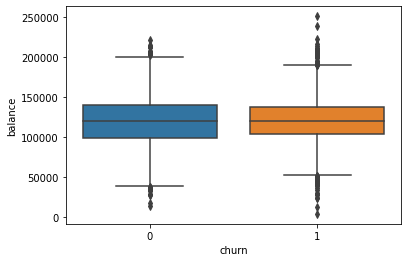

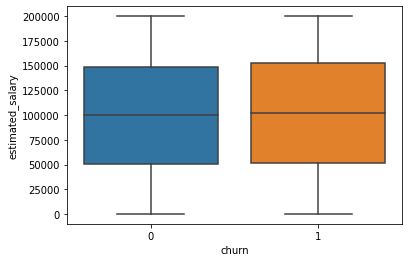

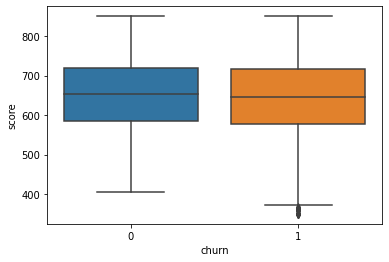

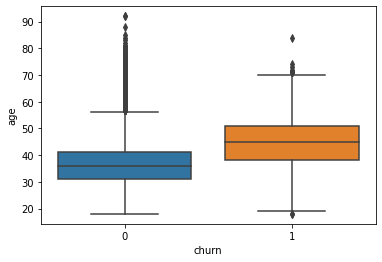

In [15]:
# А для непревывных – боксплот (так мы избежим наложения распределений и отразим именно распределения)
for col in ['balance', 'estimated_salary', 'score', 'age']:
    sns.boxplot(data=data, y=col, x='churn')
    plt.show()

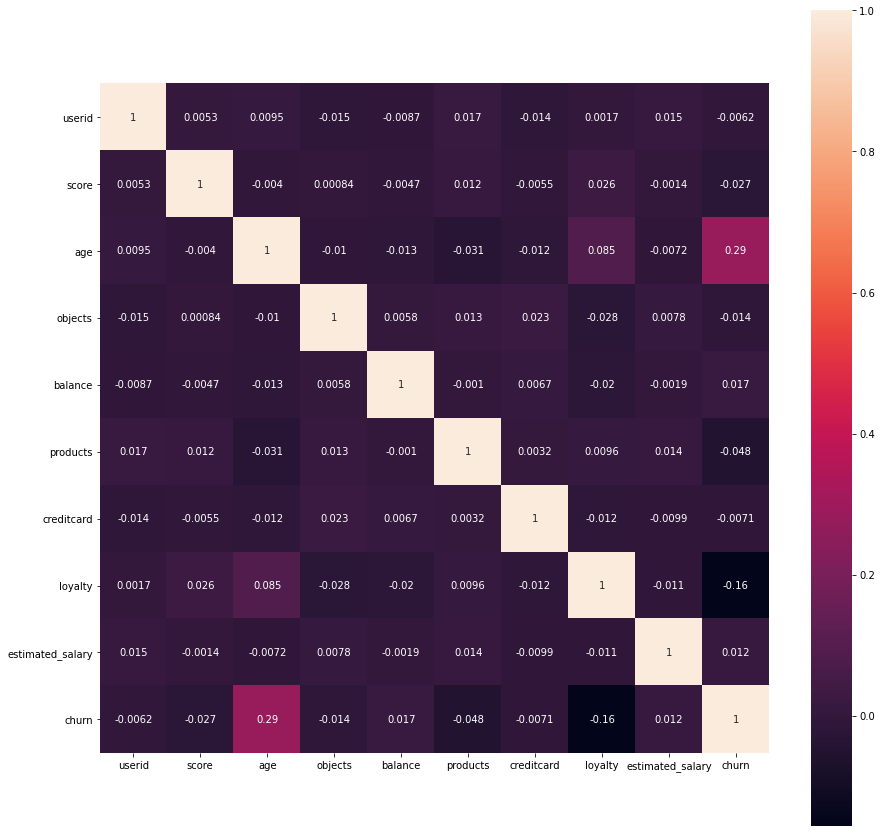

In [16]:
#построим и отрисуем матрицу корреляций
cm = data.corr()

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)

#нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm, annot=True, square=True)
# sns.set(rc={'figure.figsize':(20,18)})
plt.show()

In [17]:
# посмотрим, как соотносятся классы для нашего набора данных
data['churn'].value_counts()

0    7963
1    2037
Name: churn, dtype: int64

##### Анализ в разрезе городов

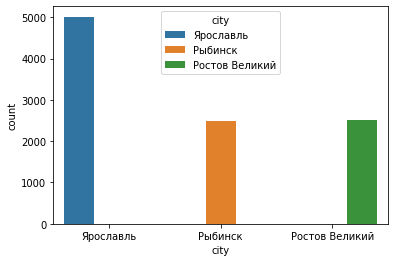

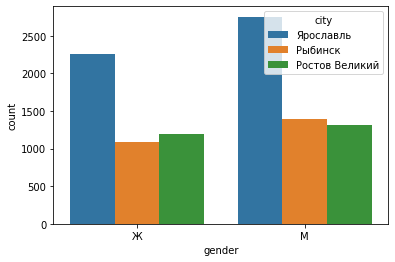

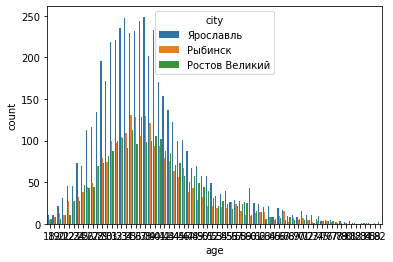

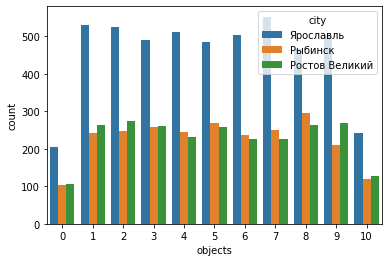

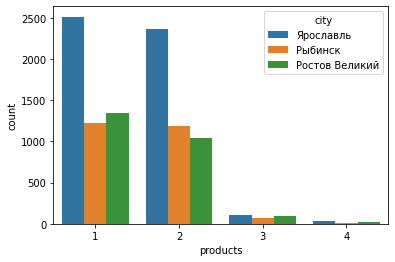

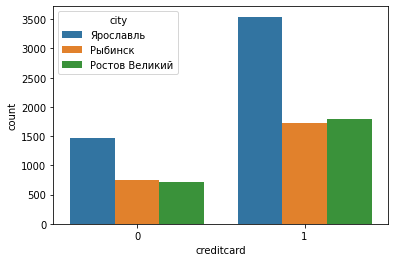

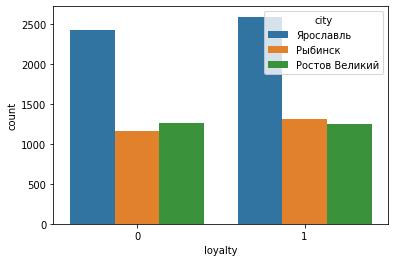

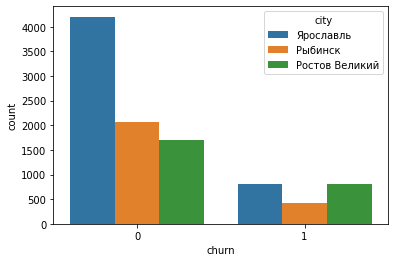

In [18]:
# Для дискретных переменных строим обычные столбчатые диаграммы.
for col in data.drop(['balance', 'estimated_salary', 'userid', 'score'], axis = 1).columns:
    sns.countplot(data=data, x=col, hue='city')
    plt.show()

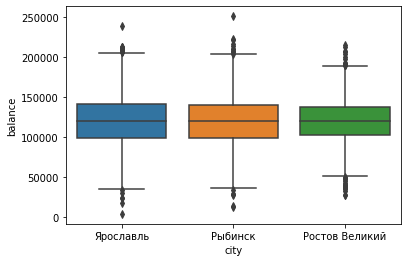

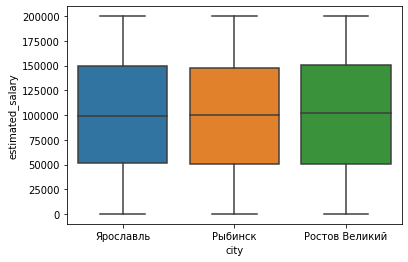

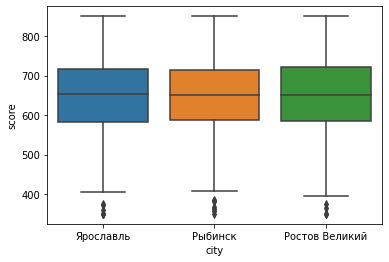

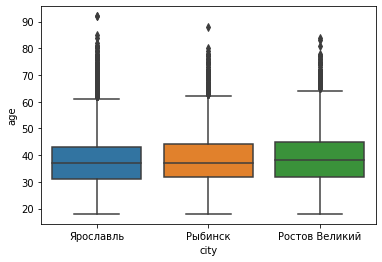

In [19]:
# А для непревывных – боксплот (так мы избежим наложения распределений и отразим именно распределения)
for col in ['balance', 'estimated_salary', 'score', 'age']:
    sns.boxplot(data=data, y=col, x='city')
    plt.show()

видим, что большинство клиентов в выборке из города Ярославль.

В каждом городе преобладает мужская половина

В целом, распределения фичей по городам не имеют значимых различий

##### Анализ непрерывных в разбивке по бинам

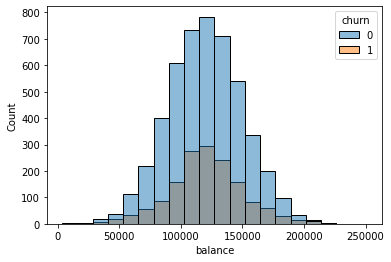

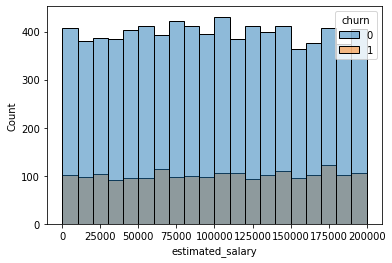

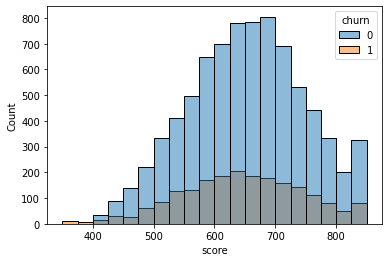

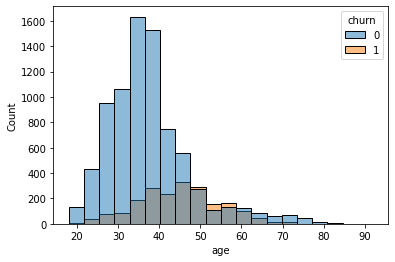

In [20]:
for col in ['balance', 'estimated_salary', 'score', 'age']:
    sns.histplot(data=data, x=col, bins=20, hue='churn')
    plt.show()

###### Вывод

- выборка не сбалансирована по таргету
- имеется высокая корреляция возраста с таргетом

## Формирование и проверка статистических гипотез

- Проверка гипотезы различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним.
- Проверка гипотезы различия дохода между теми клиентами, у которых есть кредитная карта и теми, у кого ее нет

In [21]:
alpha = 0.05

print(f"Пороговое значение равно: {alpha}")

Пороговое значение равно: 0.05


In [22]:
def check_hyp(obj, query1, query2):
    
    hyp_pv = stat.ttest_ind(data.query(query1)[obj], 
                              data.query(query2)[obj], 
                              equal_var=True)
    print('p-значение: ', hyp_pv.pvalue)
    
    if hyp_pv.pvalue < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу') 

In [23]:
# проверка первой гипотезы
check_hyp('estimated_salary', "objects == 2", "objects == 1")

p-значение:  0.39574285959300093
Не получилось отвергнуть нулевую гипотезу


In [24]:
# проверка второй гипотезы
check_hyp('estimated_salary', "creditcard == 0", "creditcard == 1")

p-значение:  0.32059213597636266
Не получилось отвергнуть нулевую гипотезу


###### Вывод
- За нулевые гипотезы (H0) были взяты утверждения: 
    - Средние доходы между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним, одинаковые
    - Средние доходы между теми клиентами, у которых есть кредитная карта и теми, у кого ее нет, одинаковые
- Альтернативные гипотезы (H1): Средний доходы различны (соответственно для каждой H0)
- Пороговое значение alpha было задано 0.05

Была проведена проверка гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, в результате которой мы не смогли отвергнуть нулевые гипотезы

## Сегментирование пользователей на основе данных о количестве потребляемых продуктов

Отложить в сторону столбец с оттоком и провести кластеризацию объектов (клиентов):
- Стандартизировать данные
- Построить матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисовать дендрограмму
- Обучить модель кластеризации на основании алгоритма K-Means и спрогнозировать кластеры клиентов.
- Использовать подбор гиперпараметров для обеспечения лучшего качества модели
- Проанализировать средние значения признаков для кластеров
- Построить распределения признаков для кластеров
- Для каждого полученного кластера посчитать долю оттока

In [25]:
X = data.drop('churn', axis = 1)
y = data['churn']

In [26]:
onehotencoder = OneHotEncoder(sparse=False)
x = onehotencoder.fit_transform(X[['city', 'gender']])
column_name = onehotencoder.get_feature_names(['city', 'gender'])
one_hot_encoded_frame =  pd.DataFrame(x, columns=column_name)
one_hot_encoded_frame

,city_Ростов Великий,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
0,0.00,0.00,1.00,1.00,0.00
1,0.00,1.00,0.00,1.00,0.00
2,0.00,0.00,1.00,1.00,0.00
3,0.00,0.00,1.00,1.00,0.00
4,0.00,1.00,0.00,1.00,0.00
...,...,...,...,...,...
9995,0.00,0.00,1.00,0.00,1.00
9996,0.00,0.00,1.00,0.00,1.00
9997,0.00,0.00,1.00,1.00,0.00
9998,1.00,0.00,0.00,0.00,1.00


In [27]:
X = X.join(one_hot_encoded_frame)
X = X.drop(['city', 'gender'], axis=1)
X['balance'] = X['balance'].fillna(0)
X.head(1)

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,city_Ростов Великий,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
0,15677338,619,42,2,0.00,1,1,1,"101,348.88",0.00,0.00,1.00,1.00,0.00


In [28]:
# обязательная стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward') 

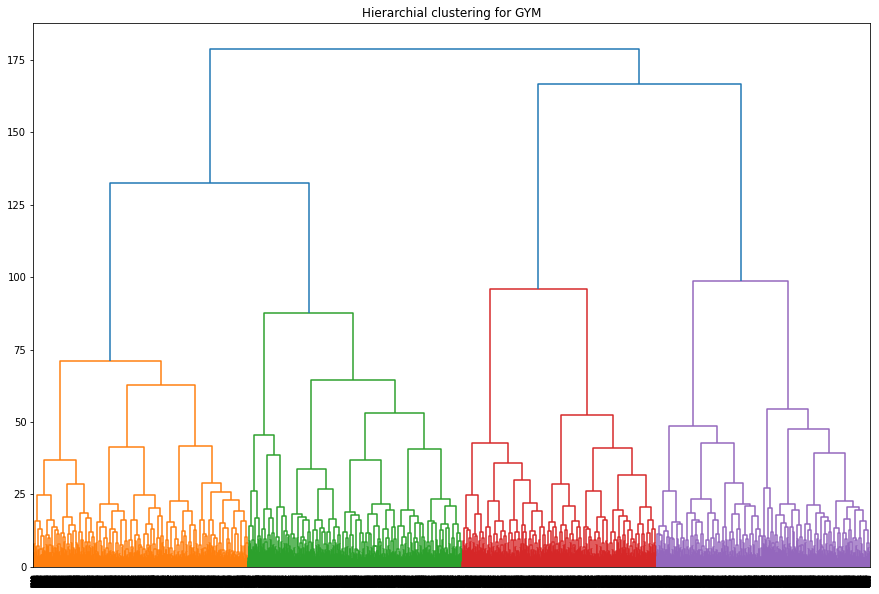

In [29]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show() 

In [30]:
km = KMeans(n_clusters=4, random_state=0) # задаём число кластеров, равное 4, и фиксируем значение random_state для воспроизводимости результата
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров 

In [31]:
# сохраняем метки кластера в поле нашего датасета
X['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
pd.DataFrame(X.groupby('cluster_km').mean())

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,city_Ростов Великий,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
cluster_km,,,,,,,,,,,,,,
0,"15,733,291.65",651.45,39.77,5.01,"119,730.12",1.52,0.71,0.50,"101,113.44",1.00,0.00,0.00,0.48,0.52
1,"15,732,029.21",650.06,38.30,5.05,"63,546.28",1.52,0.71,0.52,"100,174.25",0.00,0.00,1.00,0.00,1.00
2,"15,734,654.41",651.33,38.89,5.03,"61,818.15",1.54,0.69,0.53,"99,440.57",0.00,1.00,0.00,0.44,0.56
3,"15,735,038.29",649.19,38.77,4.95,"60,322.67",1.55,0.70,0.51,"99,564.25",0.00,0.00,1.00,1.00,0.00


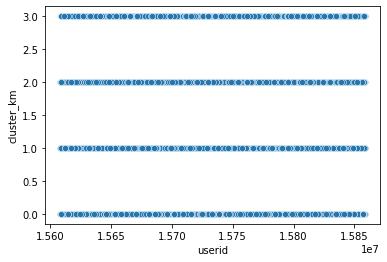

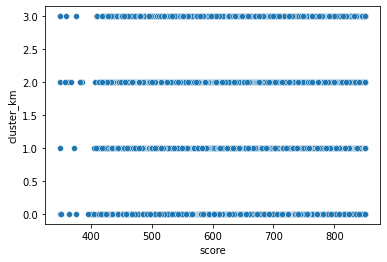

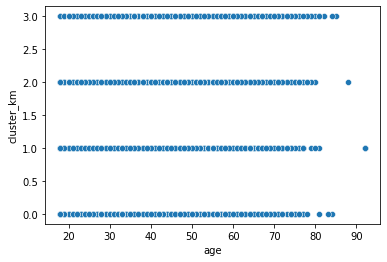

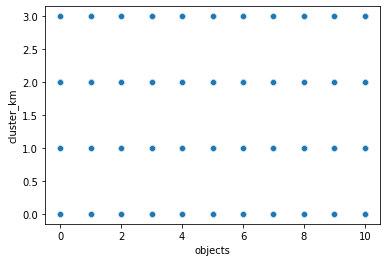

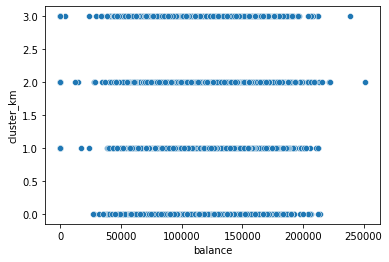

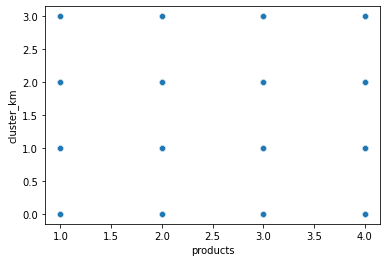

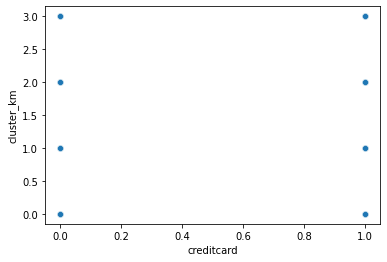

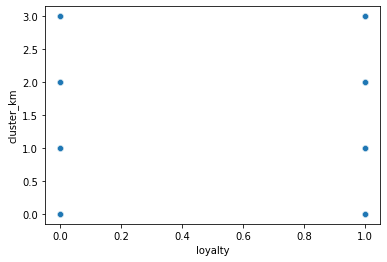

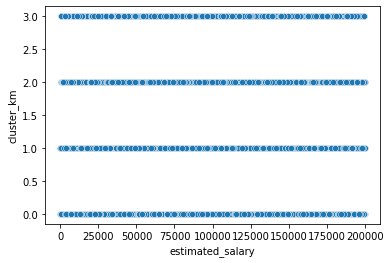

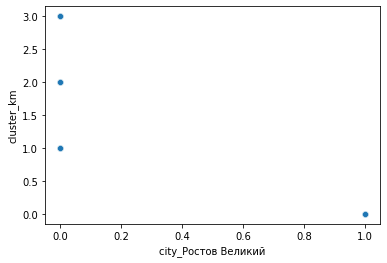

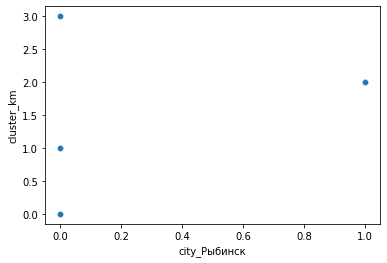

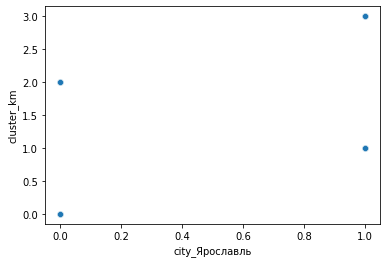

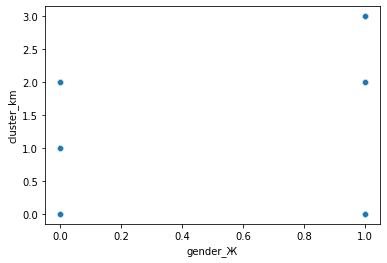

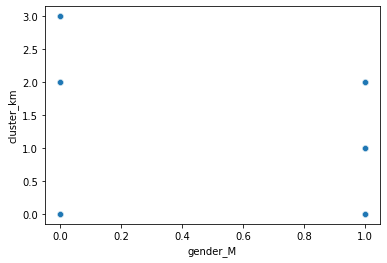

In [32]:
#распределения признаков для кластеров
for col in X.drop('cluster_km', axis = 1).columns:
    sns.scatterplot(x=X[col], y=X['cluster_km'])
    plt.show()

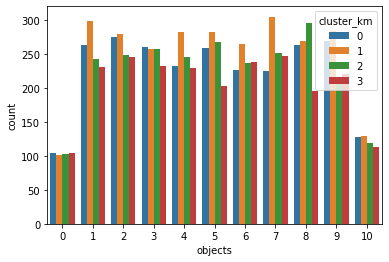

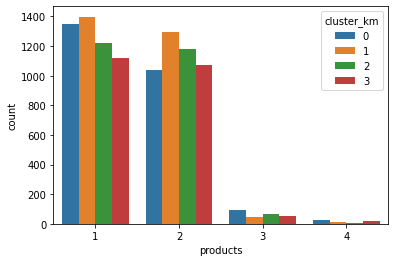

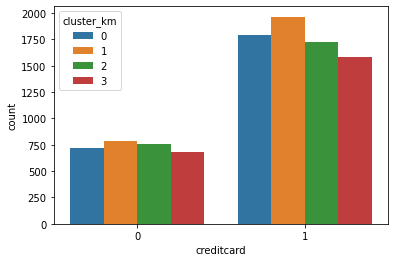

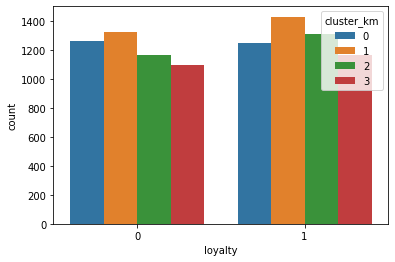

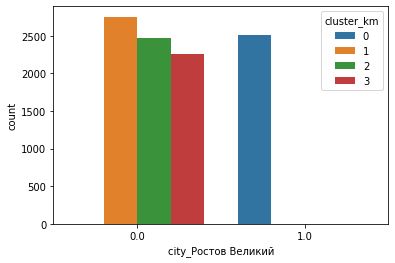

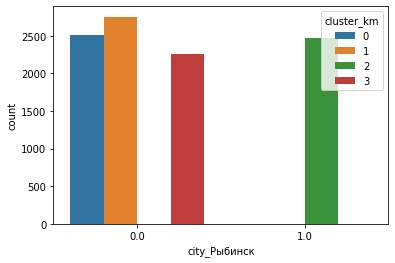

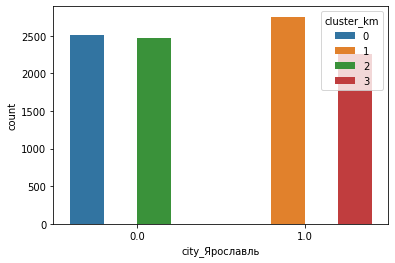

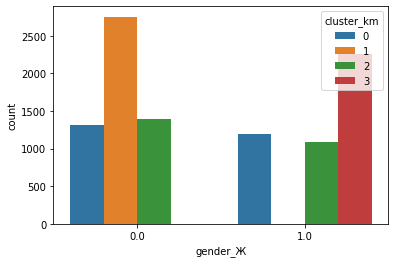

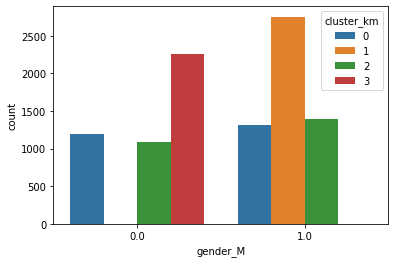

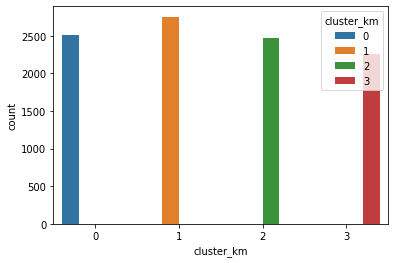

In [33]:
# Для дискретных переменных строим обычные столбчатые диаграммы.
for col in X.drop(['balance', 'estimated_salary', 'userid', 'score', 'age'], axis = 1).columns:
    sns.countplot(data=X, x=col, hue='cluster_km')
    plt.show()

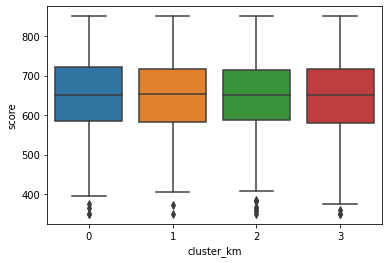

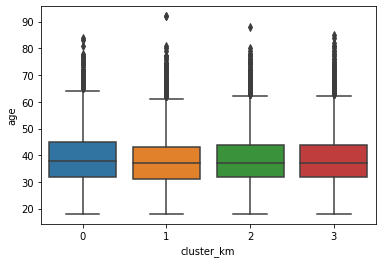

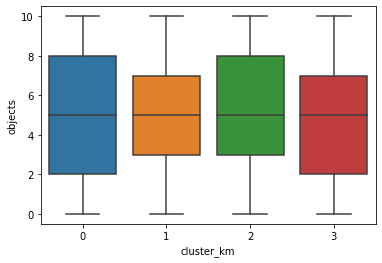

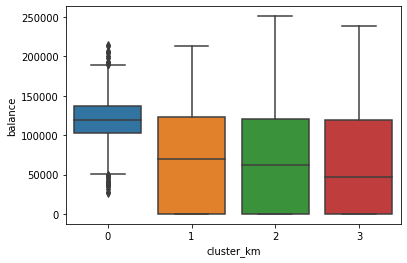

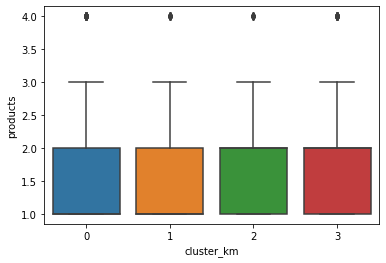

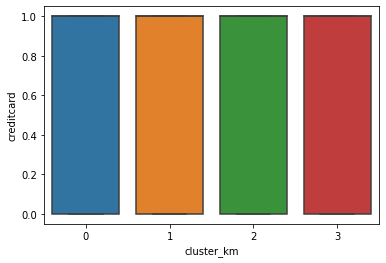

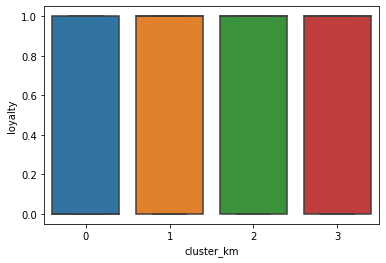

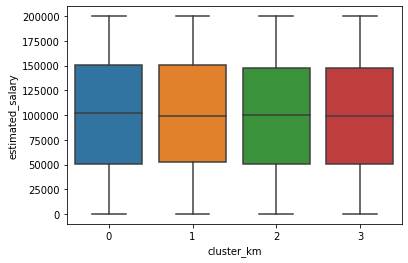

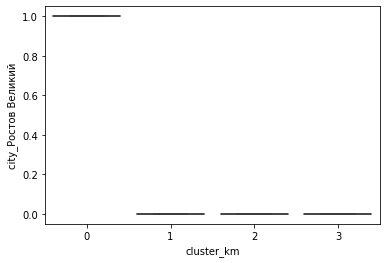

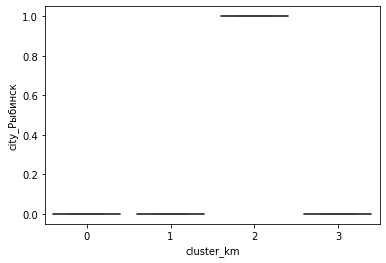

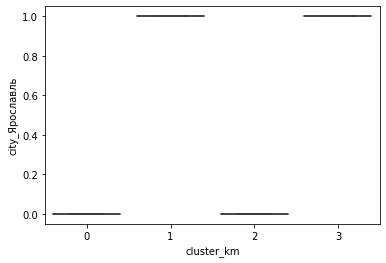

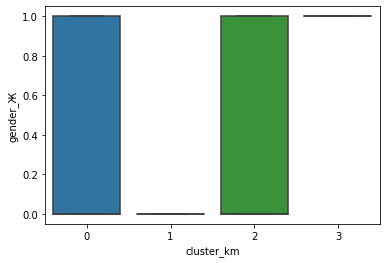

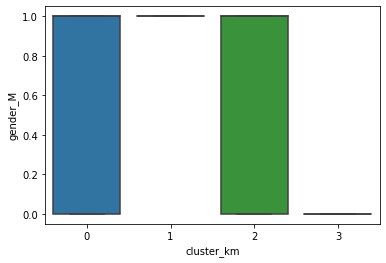

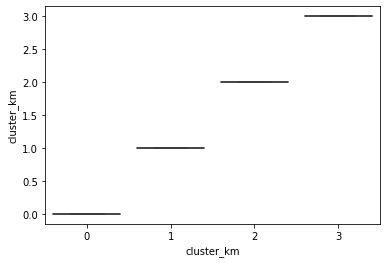

In [34]:
# А для непревывных – боксплот (так мы избежим наложения распределений и отразим именно распределения)
for col in X.drop(['userid'], axis = 1).columns:
    sns.boxplot(data=X, y=col, x='cluster_km')
    plt.show()

In [35]:
# доля оттока для кластеров

X_churn = X
X_churn['churn'] = y

X_churn.groupby('cluster_km')['churn'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster_km,,,,,,,,
0,"2,509.00",0.32,0.47,0.00,0.00,0.00,1.00,1.00
1,"2,753.00",0.13,0.33,0.00,0.00,0.00,0.00,1.00
2,"2,477.00",0.17,0.37,0.00,0.00,0.00,0.00,1.00
3,"2,261.00",0.20,0.40,0.00,0.00,0.00,0.00,1.00


# Формулирование выводов и базовых рекомендации

На основе дендрограммы, построенной из матрицы расстояний функцией linkage() на стандартизованной матрице признаков, можно сделать вывод что будет достаточно 4 кластеров

Также обучили модель кластеризации, считая, что оптимальное число кластеров 4, на основании алгоритма K-Means и спрогнозировали кластеры клиентов. По предикту модели можно сделать следующие выводы:
- средние значения признаков для кластеров в целом равномерно распределены, однако выделяется ряд различий:
    - в кластер 0 не попали клиенты с маленьким балансом
    - в кластере 0 клиенты с наибольшим оттоком
    
Диаграммы распределения признаков для кластеров также подтверждает вышеобозначенные факты

Кластера отличаются по доле оттока: наибольший отток у кластера 0, наименьший - 1. Причем разница оттока между 0 и 1 кластером более чем в 2 раза

В качестве основной рекомендации можно обозначить задачу по большей лояльности к клиентам 40+ лет. Среди них наибольший отток, следовательно надо продумать предложения по удержанию, предпочтительных для этого сегмента клиентов.